In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
a = dir(datasets)

for text in a:
    if "mnist" in text.lower():
        print(text)

EMNIST
FashionMNIST
KMNIST
MNIST
MovingMNIST
QMNIST
mnist
moving_mnist


In [5]:
ROOT_DIR = "./dataset/"

# merges letters that have similar upper and lower cases, like C:c and W:w
SPLIT_DATA_BY = "bymerge"


def TRANSFORM_CALLABLE(img: Image.Image) -> torch.Tensor:
    return ToTensor()(img.transpose(Image.TRANSPOSE))

training_data = datasets.EMNIST(root=ROOT_DIR, split=SPLIT_DATA_BY, train=True, download=True, transform=TRANSFORM_CALLABLE)
testing_data = datasets.EMNIST(ROOT_DIR, split=SPLIT_DATA_BY, train=False, download=True, transform=TRANSFORM_CALLABLE)

print(training_data)
print(testing_data)

Dataset EMNIST
    Number of datapoints: 697932
    Root location: ./dataset/
    Split: Train
    StandardTransform
Transform: <function TRANSFORM_CALLABLE at 0x7f465386a440>
Dataset EMNIST
    Number of datapoints: 116323
    Root location: ./dataset/
    Split: Test
    StandardTransform
Transform: <function TRANSFORM_CALLABLE at 0x7f465386a440>


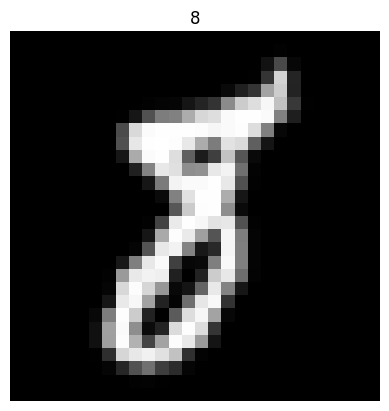

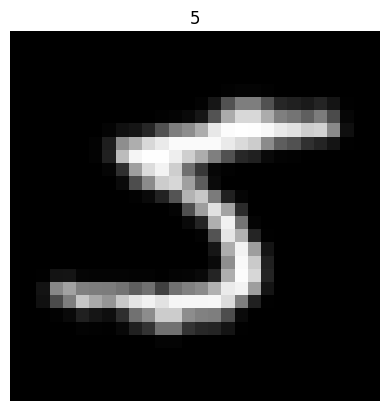

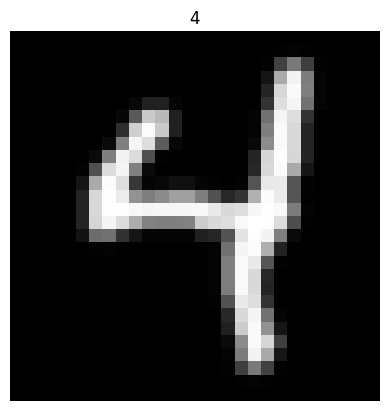

In [6]:
for i in range(3):
    rand_ind = torch.randint(len(training_data), size=(1,)).item()
    assert isinstance(rand_ind, int)

    img, label = training_data[rand_ind]
    img_class = training_data.classes[label]
    
    assert isinstance(img, torch.Tensor) and img.shape == (1, 28, 28)

    plt.imshow(img[0], cmap="gray")
    plt.title(img_class)
    plt.axis("off")
    plt.show()


In [7]:
BATCH_SIZE = 64

training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE)

X, y = next(iter(testing_dataloader))

print(X.shape, X.dtype)
print(y.shape, y.dtype)

torch.Size([64, 1, 28, 28]) torch.float32
torch.Size([64]) torch.int64


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


/home/liheng/.local/share/virtualenvs/ocr-train-cWreNkmb/lib/python3.10/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
class TheModel(nn.Module):
    def __init__(self, output_dim):
        super().__init__() 
        self.sequential = nn.Sequential(
            nn.Conv2d(1, 16, 5, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 16, 5, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            # nn.Conv2d(16, 16, 3, 2, 1),
            # nn.ReLU(),
            # nn.BatchNorm2d(16),
            # nn.MaxPool2d(2),

            # nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16, output_dim),
            nn.LogSoftmax(1),
        )

    def forward(self, x):
        return self.sequential(x)


model = TheModel(len(training_data.classes)).to(device)
print(model)


TheModel(
  (sequential): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=16, out_features=47, bias=True)
    (10): LogSoftmax(dim=1)
  )
)


In [10]:
loss_func = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 1e-3)

def train(dataloader, model, loss_func, optimizer):
    N = len(dataloader.dataset)
    model.train()

    for ind_batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        forward = model(X)
        loss = loss_func(forward, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if ind_batch % 100 == 0:
            loss_val, current = loss.item(), (ind_batch + 1) * len(X)
            print(f"loss: {loss_val:>7f}  {current:>5d}/{N:>5d}")


def test(dataloader, model, loss_func):
    N = len(dataloader.dataset)
    average_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            inference = model(X)
            average_loss += loss_func(inference, y).item()
            correct += (inference.argmax(1) == y).sum().item()
    
    average_loss /= len(dataloader)
    correct /= N

    print(f"% correct: {(100 * correct):>0.1f}  avg loss: {average_loss:>7f}")

In [11]:
EPOCHS = 5
for ep in range(EPOCHS):
    print(f"Epoch {ep}\n---")
    train(training_dataloader, model, loss_func, optimizer)
    test(testing_dataloader, model, loss_func)

Epoch 0
---
loss: 4.515458     64/697932


loss: 3.840013   6464/697932
loss: 3.547712  12864/697932
loss: 3.301851  19264/697932
loss: 3.130040  25664/697932
loss: 2.844040  32064/697932
loss: 2.884674  38464/697932
loss: 2.816006  44864/697932
loss: 3.085298  51264/697932
loss: 2.777089  57664/697932
loss: 2.378725  64064/697932
loss: 2.362000  70464/697932
loss: 2.807441  76864/697932
loss: 2.272045  83264/697932
loss: 2.494200  89664/697932
loss: 2.369204  96064/697932
loss: 2.249467  102464/697932
loss: 2.165577  108864/697932
loss: 2.142003  115264/697932
loss: 1.919924  121664/697932
loss: 2.190131  128064/697932
loss: 2.187688  134464/697932
loss: 2.107673  140864/697932
loss: 1.903810  147264/697932
loss: 2.220697  153664/697932
loss: 2.282322  160064/697932
loss: 1.955062  166464/697932
loss: 1.881606  172864/697932
loss: 1.615279  179264/697932
loss: 2.051400  185664/697932
loss: 1.685832  192064/697932
loss: 2.149636  198464/697932
loss: 2.144240  204864/697932
loss: 2.150355  211264/697932
loss: 1.746874  217664/69

KeyboardInterrupt: 